# Import libraries

In [1]:
import sys
sys.path.append(r'/home/gishb/PycharmProjects/MLTdataanalysis') 

import libs_cpd
import itertools

# Define syth data class

In [2]:
class SythDataGenerator:
    """SythDataGenerator class (SDG).

    This class helps to generate syth data for CPD experiments.

    Note:
        At SDG class we have 1 group of function. It is step_rate_function which generate steps function with some noise.

    Args:
        number_steps: numbers of CPs.
        length: size of 1D time series which you expect to get.
        mess_rate: it is called np.random.randint where mess rate is std value for Gaussian distribution.
        normalization: normalize or not output list of syth data.
        savgol_filter: filter or not output list of syth data.

    """
    def __init__(self,
                 number_steps: int = 1,
                 length: int = 100,
                 mess_rate: float = 0,
                 normalization: bool = True,
                 savgol: bool = False):
    
        self.number_steps = number_steps
        self.length = length
        self.mess_rate = mess_rate
        self.normalization = normalization
        self.savgol = savgol
        
    def step_rate_function(self, number_steps: int, length: int, mess_rate: float) -> list:
        random_value = libs_cpd.np.random.randint(-length, length)
        function = [self.gaussian_mess(x=random_value-libs_cpd.np.random.randint(-length, length), mess_rate=mess_rate, size=length//(number_steps+1))\
                    for w in range(number_steps+1)]
        cps_list = [[0 for i in range(length//(number_steps+1)-1)]+[1] if w != number_steps\
                    else [0 for i in range(length//(number_steps+1)-1)]+[0] for w in range(number_steps+1)]
        return list(itertools.chain.from_iterable(function)), list(itertools.chain.from_iterable(cps_list))

    def gaussian_mess(self, x: float, mess_rate: float, size: int) -> float:
        return libs_cpd.np.random.normal(loc=x, scale=mess_rate, size=size)

    def normalization_linear(self, x: list) -> list:
        return (x-min(x))/(max(x)-min(x))
    
    def filter_Savgol(self, x: list, window_length: int) -> list:
        return libs_cpd.savgol_filter(x, window_length, 3, mode='nearest')
    
    def wss(self, x: list) -> int:
        return libs_cpd.WindowSizeSelection(time_series = x,
                                       wss_algorithm = 'summary_statistics_subsequence').get_window_size()[0]
    
    def runner(self):
        out, cps = self.step_rate_function(number_steps=self.number_steps, length=self.length, mess_rate=self.mess_rate)
        if self.normalization:
            out = self.normalization_linear(out)
        if self.savgol:
            out = self.filter_Savgol(out, self.wss(out))
        return list(out), cps

# Generate test data

In [3]:
low_syth = SythDataGenerator(20, 1000, 0, True)
mid_syth = SythDataGenerator(20, 1000, 500, True)
high_syth = SythDataGenerator(20, 1000, 1000, True)

In [4]:
low_data = low_syth.runner()
mid_data = mid_syth.runner()
high_data = high_syth.runner()

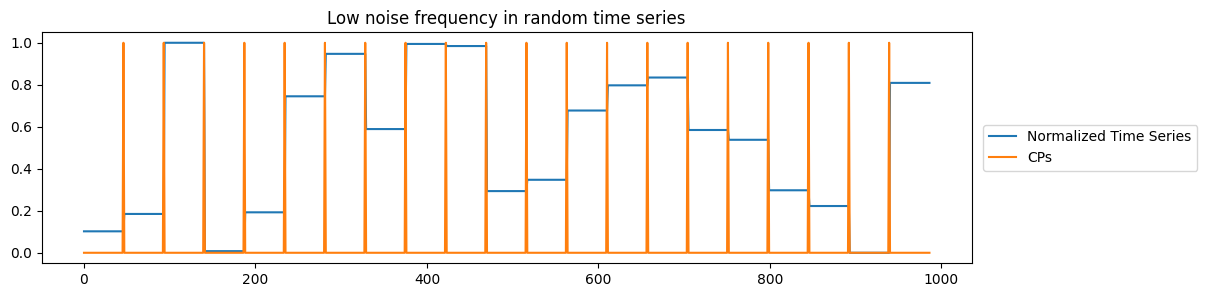

In [5]:
libs_cpd.plt.figure(figsize=(12,3))
libs_cpd.plt.plot(low_data[0], label='Normalized Time Series')
libs_cpd.plt.plot(low_data[1], label='CPs')
libs_cpd.plt.title('Low noise frequency in random time series')
libs_cpd.plt.legend(loc="center right" , bbox_to_anchor=(1.25, 0.5))

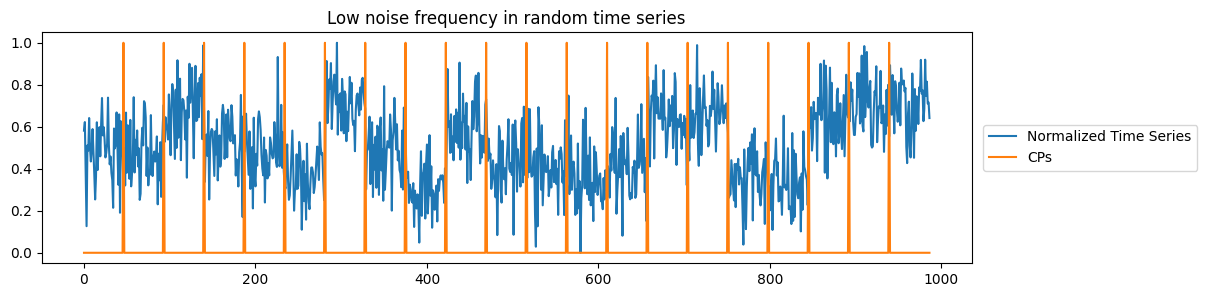

In [6]:
libs_cpd.plt.figure(figsize=(12,3))
libs_cpd.plt.plot(mid_data[0], label='Normalized Time Series')
libs_cpd.plt.plot(mid_data[1], label='CPs')
libs_cpd.plt.title('Low noise frequency in random time series')
libs_cpd.plt.legend(loc="center right" , bbox_to_anchor=(1.25, 0.5))

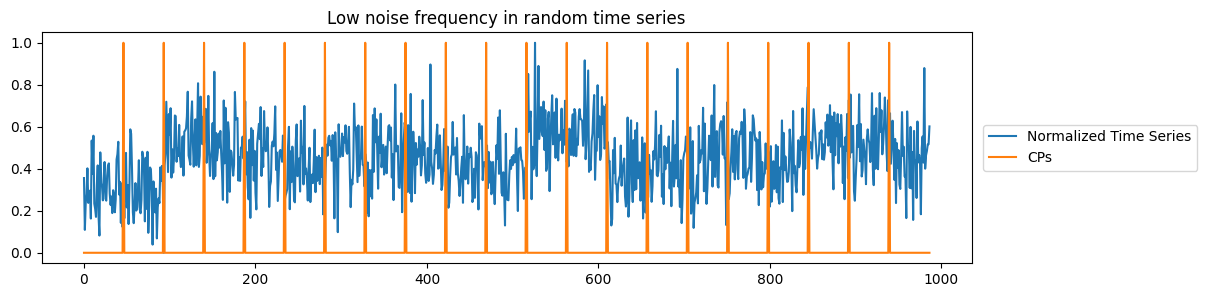

In [7]:
libs_cpd.plt.figure(figsize=(12,3))
libs_cpd.plt.plot(high_data[0], label='Normalized Time Series')
libs_cpd.plt.plot(high_data[1], label='CPs')
libs_cpd.plt.title('Low noise frequency in random time series')
libs_cpd.plt.legend(loc="center right" , bbox_to_anchor=(1.25, 0.5))

# WSS block

In [8]:
window_length_small = libs_cpd.WindowSizeSelection(time_series = low_data[0],
                                       wss_algorithm = 'summary_statistics_subsequence').get_window_size()[0]

In [9]:
window_length_mid = libs_cpd.WindowSizeSelection(time_series = mid_data[0],
                                       wss_algorithm = 'summary_statistics_subsequence').get_window_size()[0]

In [10]:
window_length_high = libs_cpd.WindowSizeSelection(time_series = high_data[0],
                                       wss_algorithm = 'summary_statistics_subsequence').get_window_size()[0]

# Kalman Filter Block

In [11]:
gaussian = libs_cpd.namedtuple('Gaussian', ['mean', 'var'])
gaussian.__repr__ = lambda s: '𝒩(μ={:.3f}, 𝜎²={:.3f})'.format(s[0], s[1])

def gaussian_multiply(g1, g2):
    mean = (g1.var * g2.mean + g2.var * g1.mean) / (g1.var + g2.var)
    variance = (g1.var * g2.var) / (g1.var + g2.var)
    return gaussian(mean, variance)

def update(prior, likelihood):
    posterior = gaussian_multiply(likelihood, prior)
    return posterior

def predict(pos, movement):
    return gaussian(pos.mean + movement.mean, pos.var + movement.var)

In [12]:
def online_detection(time_series=list(), window=20, queue_window=10, treshold_coef=3):
    ''' 
        An online implementation of Kalman Filter Change Point Detection based on risiduals,
    and current time-series statistics for treshold updating.
    
    Note:
        queue_window - min possible distance between two predicted CPs.
        treshold_coef - if residuals above this treshold than we can detect CP. Based on np.meean + 3*np.std
        where 3 is the coef.
        window - the length of data which we save in memory.
    '''
    
    dp = [0]*window #массив с предсказаниями по CPs
#     queue_risiduals = [0]*window #очередь с рядом остатков по которому отбивают трешхолд
    queue_risiduals = [0 for i in range(window)]
#     queue_cp = [0]*queue_window #очередь CPs
    queue_cp = [0 for i in range(queue_window)]
    queue_ts = time_series[:window] #р
    queue_gaussian = [gaussian(libs_cpd.np.mean(queue_ts), libs_cpd.np.var(queue_ts)),\
                     gaussian(libs_cpd.np.mean(queue_ts), libs_cpd.np.var(queue_ts))]
    
    for i in range(window, len(time_series)): #Это цикл позволяет нам получать данные раз в 9 секунд условно.
        gaussian_likelihood = queue_gaussian[0] #смотрим начальное состояние MEAN VAR
        gaussian_prior = gaussian(libs_cpd.np.mean(queue_ts), libs_cpd.np.var(queue_ts)) #смотрим обновление состояние MEAN VAR

        x = update(gaussian_prior, gaussian_likelihood) #обновляем значение MEAN VAR
        queue_gaussian.pop(0) #удаляем старое значение
        queue_gaussian.append(gaussian_prior) #добавляем новое значение likelihood
        
        next_prediction = libs_cpd.np.random.normal(loc=x.mean) #Генерируем значение исходя из нового знания об gaussian
        next_value = time_series[i] #П
        risidual_value = abs(next_prediction - next_value)
        
        mean_risidual_prev = libs_cpd.np.mean(queue_risiduals)
        std_risidual_prev = libs_cpd.np.std(queue_risiduals)
        queue_risiduals.pop(0) # удаляем старое значение risiduals
        queue_risiduals.append(risidual_value) #новое значение risiduals
        
        if risidual_value >= mean_risidual_prev + std_risidual_prev*treshold_coef: #проверка что мы нашли переход
            if max(queue_cp) != 1: #queue filter IF
                queue_cp.pop(0)
                queue_cp.append(1)
                dp.append(1)
            else: #queue filter else
                queue_cp.pop(0)
                queue_cp.append(0)
                dp.append(0)
        else:
                dp.append(0)
                queue_cp.pop(0)
                queue_cp.append(0)

        
        queue_ts.pop(0) #удаляем из очереди старое значение VALUE
        queue_ts.append(next_value) #добавляем в очередь новое значение VALUE
    return dp

In [13]:
cps_low = online_detection(low_data[0], window=window_length_small, queue_window=10, treshold_coef=4.2)

/tmp/ipykernel_26415/1679937943.py:5: RuntimeWarning: invalid value encountered in scalar divide
  mean = (g1.var * g2.mean + g2.var * g1.mean) / (g1.var + g2.var)
/tmp/ipykernel_26415/1679937943.py:6: RuntimeWarning: invalid value encountered in scalar divide
  variance = (g1.var * g2.var) / (g1.var + g2.var)


In [14]:
cps_mid = online_detection(mid_data[0], window=window_length_mid, queue_window=10, treshold_coef=4.2)

In [15]:
cps_high = online_detection(high_data[0], window=window_length_high, queue_window=10, treshold_coef=4.2)

# SST block

# Data Creator stage

This is necessary for TSAD evaluations

In [16]:
df_low = libs_cpd.pd.DataFrame()
df_mid = libs_cpd.pd.DataFrame()
df_high = libs_cpd.pd.DataFrame()

In [17]:
df_low['cps_original'] = low_data[1]
df_mid['cps_original'] = mid_data[1]
df_high['cps_original'] = high_data[1]

In [18]:
df_low['cps_predicted'] = cps_low
df_mid['cps_predicted'] = cps_mid
df_high['cps_predicted'] = cps_high

In [19]:
df_low['ts'] = low_data[0]
df_mid['ts'] = mid_data[0]
df_high['ts'] = high_data[0]

In [20]:
df_low['time'] = libs_cpd.np.arange(0, len(df_low)*1, 1).astype('datetime64[s]')
df_low = df_low.set_index('time')
df_mid['time'] = libs_cpd.np.arange(0, len(df_mid)*1, 1).astype('datetime64[s]')
df_mid = df_mid.set_index('time')
df_high['time'] = libs_cpd.np.arange(0, len(df_high)*1, 1).astype('datetime64[s]')
df_high = df_high.set_index('time')

# Create report

In [21]:
def create_report(experiment_results: dict):
    experiment_df = libs_cpd.pd.DataFrame.from_dict(experiment_results, orient='index')
    experiment_df = experiment_df.fillna(0)
    return experiment_df

def tsad_average(predicted_list, original_list):
    averate_time, missed_cp, FPs, true_anomalies = libs_cpd.evaluating(original_list, predicted_list, metric='average_time', numenta_time='30 sec', verbose=False)
    TP = true_anomalies - missed_cp
    precision = TP/(TP+FPs)
    recall = TP/(TP+missed_cp)
    if precision == 0 or recall ==0:
        F1 = 0
    else:
        F1 = 2*precision*recall/(precision+recall)
    return {'Time_Delta': averate_time, 'Missed_CP': missed_cp, 'FPs': FPs, 'True_Anomalies_Count': true_anomalies, 'precision':precision, 'recall':recall,'F1':F1}

def tsad_nab(predicted_list, original_list):
    nab = libs_cpd.evaluating(original_list, predicted_list, metric='nab', numenta_time='30 sec', verbose=False)
    return nab

Look at low data results

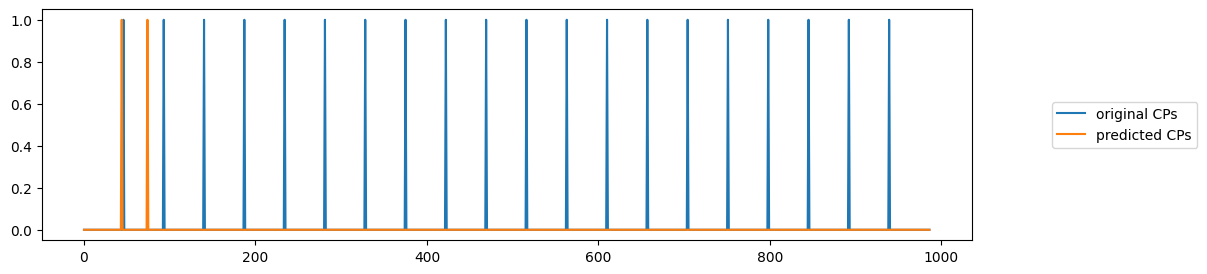

In [22]:
libs_cpd.plt.figure(figsize=(12,3))
libs_cpd.plt.plot(low_data[1], label='original CPs')
libs_cpd.plt.plot(cps_low,label='predicted CPs')
libs_cpd.plt.legend(loc="center right" , bbox_to_anchor=(1.25, 0.5))

In [23]:
%%capture --no-display
tsad_average_results = tsad_average(df_low['cps_predicted'], df_low['cps_original'])

In [24]:
%%capture --no-display
tsad_nab_results = tsad_nab(df_low['cps_predicted'], df_low['cps_original'])

In [25]:
tsad_nab_results.update(tsad_average_results)
create_report(tsad_nab_results)

,0
Standart,6.5
LowFP,6.15
LowFN,7.67
Time_Delta,0 days 00:00:10.500000
Missed_CP,18
FPs,0
True_Anomalies_Count,20
precision,1.0
recall,0.1
F1,0.181818


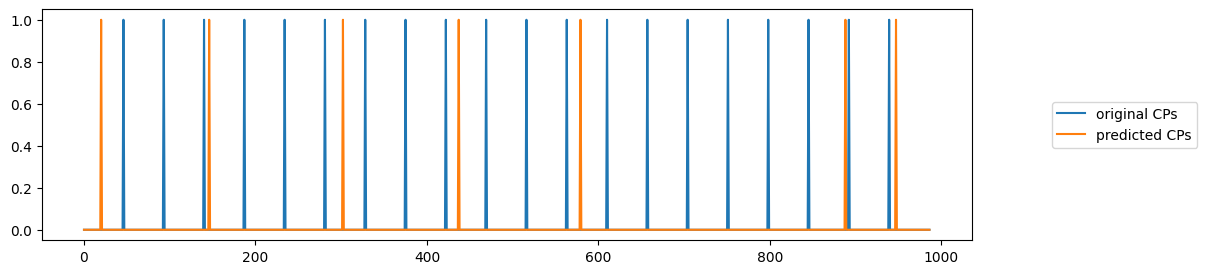

In [26]:
libs_cpd.plt.figure(figsize=(12,3))
libs_cpd.plt.plot(mid_data[1], label='original CPs')
libs_cpd.plt.plot(cps_mid,label='predicted CPs')
libs_cpd.plt.legend(loc="center right" , bbox_to_anchor=(1.25, 0.5))

In [27]:
%%capture --no-display
tsad_average_results = tsad_average(df_mid['cps_predicted'], df_mid['cps_original'])

In [28]:
%%capture --no-display
tsad_nab_results = tsad_nab(df_mid['cps_predicted'], df_mid['cps_original'])

In [29]:
tsad_nab_results.update(tsad_average_results)
create_report(tsad_nab_results)

,0
Standart,10.98
LowFP,9.59
LowFN,12.32
Time_Delta,0 days 00:00:18.666666666
Missed_CP,17
FPs,4
True_Anomalies_Count,20
precision,0.428571
recall,0.15
F1,0.222222


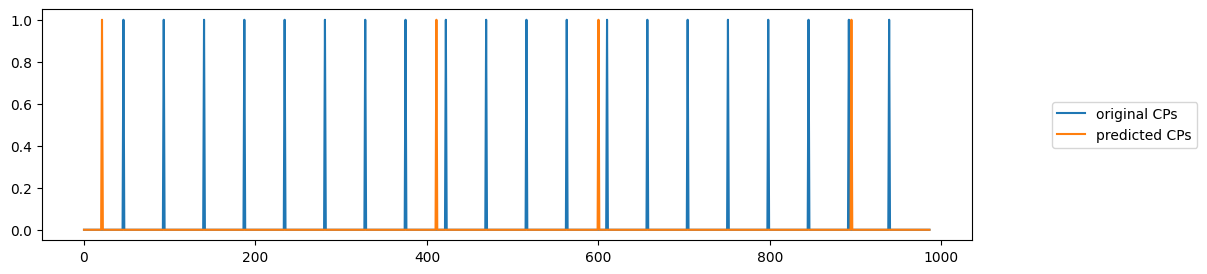

In [30]:
libs_cpd.plt.figure(figsize=(12,3))
libs_cpd.plt.plot(high_data[1], label='original CPs')
libs_cpd.plt.plot(cps_high,label='predicted CPs')
libs_cpd.plt.legend(loc="center right" , bbox_to_anchor=(1.25, 0.5))

In [31]:
%%capture --no-display
tsad_average_results = tsad_average(df_high['cps_predicted'], df_high['cps_original'])

In [32]:
%%capture --no-display
tsad_nab_results = tsad_nab(df_high['cps_predicted'], df_high['cps_original'])

In [33]:
tsad_nab_results.update(tsad_average_results)
create_report(tsad_nab_results)

,0
Standart,10.42
LowFP,9.72
LowFN,11.94
Time_Delta,0 days 00:00:15.333333333
Missed_CP,17
FPs,1
True_Anomalies_Count,20
precision,0.75
recall,0.15
F1,0.25
